In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Load & Preprocess Dataset
DATASET_PATH = "dataset"
IMG_SIZE = 128

images = []
labels = []
class_names = sorted(os.listdir(DATASET_PATH))

for idx, person in enumerate(class_names):
    person_path = os.path.join(DATASET_PATH, person)
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        images.append(img)
        labels.append(idx)

images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
labels = to_categorical(labels, num_classes=len(class_names))


In [3]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, shuffle=True
)

In [4]:
# CNN Model (From Scratch)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


c:\Users\sudip\OneDrive\Desktop\palm-recognition-csy2082\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train Model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 674ms/step - accuracy: 0.2713 - loss: 1.3588 - val_accuracy: 0.4167 - val_loss: 1.3661
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 627ms/step - accuracy: 0.3511 - loss: 1.2992 - val_accuracy: 0.2917 - val_loss: 1.3611
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 616ms/step - accuracy: 0.3830 - loss: 1.2692 - val_accuracy: 0.3750 - val_loss: 1.3481
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 541ms/step - accuracy: 0.3830 - loss: 1.2598 - val_accuracy: 0.4167 - val_loss: 1.2890
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 569ms/step - accuracy: 0.4681 - loss: 1.2007 - val_accuracy: 0.4167 - val_loss: 1.2154
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 550ms/step - accuracy: 0.5851 - loss: 1.0826 - val_accuracy: 0.6458 - val_loss: 1.1202
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 569ms/step - accuracy: 0.6862 - loss: 0.9681 - val_accuracy: 0.7292 - val_loss: 0.9775
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.7713 - loss: 0.8062 - val_accurac

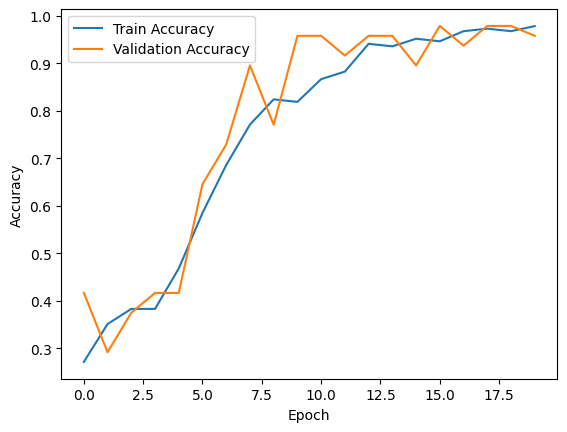

In [7]:
# Training Accuracy Graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [8]:
# Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 1.0000 - loss: 0.0470
Test Accuracy: 1.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step
[[13  0  0  0]
 [ 0 16  0  0]
 [ 0  0 15  0]
 [ 0  0  0 16]]
              precision    recall  f1-score   support

    person_1       1.00      1.00      1.00        13
    person_2       1.00      1.00      1.00        16
    person_3       1.00      1.00      1.00        15
    person_4       1.00      1.00      1.00        16

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [9]:
# from tensorflow.keras.models import Model

# embedding_model = Model(
#     inputs=model.input,
#     outputs=model.layers[-2].output  # Dense(128)
# )


from tensorflow.keras.models import Model

embedding_model = Model(
    inputs=model.layers[0].input,  # Get input directly from the first layer
    outputs=model.layers[-2].output  # Dense(128)
)

In [10]:
import pickle

reference_embeddings = {}
EMBEDDING_THRESHOLD = 1.2

for person in class_names:
    embeddings = []
    person_path = os.path.join(DATASET_PATH, person)

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

        emb = embedding_model.predict(img)[0]
        embeddings.append(emb)

    reference_embeddings[person] = np.mean(embeddings, axis=0)

with open("reference_embeddings.pkl", "wb") as f:
    pickle.dump(reference_embeddings, f)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [11]:
# Save Model
model.save("palm_recognition_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


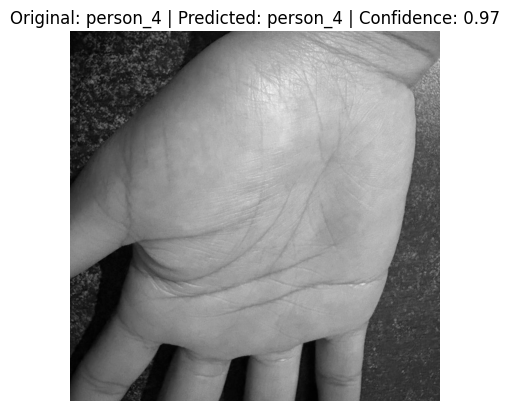

In [12]:
# Random Image Prediction Test

import random
import matplotlib.pyplot as plt

# Confidence threshold for unknown detection
CONFIDENCE_THRESHOLD = 0.6

# Pick random class
true_label = random.choice(class_names)
class_path = os.path.join(DATASET_PATH, true_label)

# Pick random image from that class
img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

# Load and preprocess image
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))
img_norm = img_resized / 255.0
img_input = img_norm.reshape(1, IMG_SIZE, IMG_SIZE, 1)

# Predict
predictions = model.predict(img_input)[0]
confidence = np.max(predictions)
predicted_index = np.argmax(predictions)

# Apply unknown logic
if confidence < CONFIDENCE_THRESHOLD:
    predicted_label = "Unknown"
else:
    predicted_label = class_names[predicted_index]

# Display results
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title(
    f"Original: {true_label} | Predicted: {predicted_label} | Confidence: {confidence:.2f}"
)
plt.show()
